In [1]:
import nd2reader
import matplotlib.pyplot as plt
import os
import numpy as np
from os import listdir
from PIL import Image
import shutil
import imageio

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

from skimage.util import *
from skimage import exposure

import cv2

In [2]:
PATH = 'data/'

def read_data(reader,PATH):
    data = []
    filenames = []
    for filename in listdir(PATH):
        if filename.endswith('.nd2'):
            data.append(reader(PATH + filename))
            filenames.append(filename)
    return data, filenames

In [3]:
reader = nd2reader.ND2Reader
samples, filenames = read_data(reader, PATH)
print("In total {} files:".format(len(filenames)))
print(*filenames, sep="\n")

In total 9 files:
18112019_SJR5_w1_5ms.nd2
18112019_SJR5_w2_30ms.nd2
18112019_SJR5_w3_30ms.nd2
18112019_SJR5_w5_30ms.nd2
18112019_SJR5_w4_30ms.nd2
18112019_SJR5_w2_5ms.nd2
18112019_SJR5_w3_5ms.nd2
18112019_SJR5_w1_30ms.nd2
18112019_SJR5_w4_5ms.nd2


In [4]:
def get_volume(sample, channel, frame):
    if channel in range(sample.sizes["c"]) and frame in range(sample.sizes["t"]):
        sample.iter_axes = 'z'
        sample.default_coords['c'] = channel
        sample.default_coords['t'] = frame
        
        volume = np.array([np.array(level) for level in sample])
        return volume

In [5]:
index_30ms = [i for i,elem in enumerate(filenames) if '30ms'in elem]
print(index_30ms)
index_5ms = [i for i in range(len(filenames)) if i not in index_30ms]
print(index_5ms)

[1, 2, 3, 4, 7]
[0, 5, 6, 8]


In [6]:
volume_s0_c0_f0 = get_volume(samples[0], channel=0, frame=0) # samples[0] refers to 5ms, which is noisier than 30ms
volume_s0_c0_f2 = get_volume(samples[0], channel=0, frame=2)

volume_s1_c0_f1 = get_volume(samples[1], channel=0, frame=1) # samples[1] refers to 30ms, which is noisier than 30ms
volume_s1_c0_f3 = get_volume(samples[1], channel=0, frame=3)

5ms sample


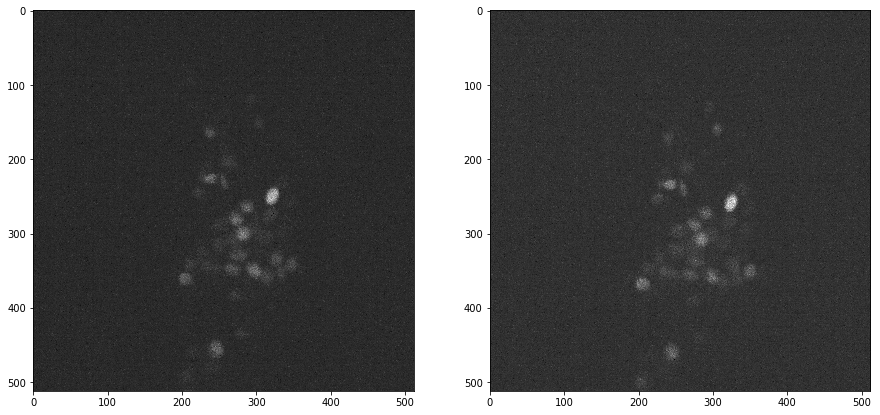

In [7]:
print('5ms sample')

level = 10

img_1 = volume_s0_c0_f0[level]
img_2 = volume_s0_c0_f2[level]

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_2, cmap="gray")
plt.show()

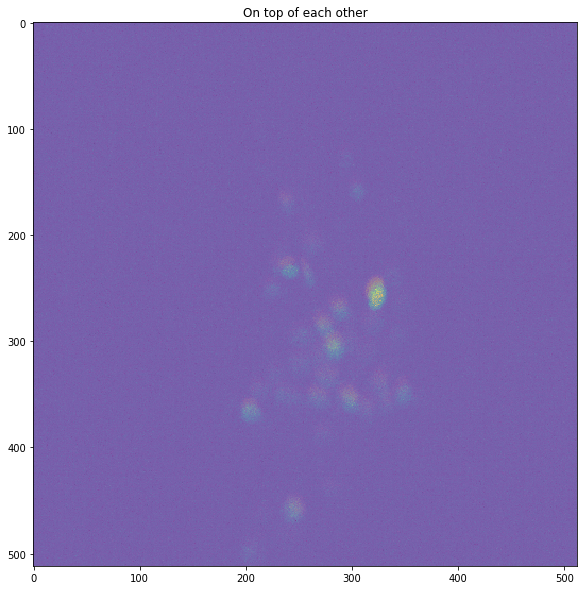

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1, cmap="plasma", alpha=0.5)
plt.imshow(img_2, cmap="viridis", alpha=0.5)
plt.title("On top of each other")
plt.show()

We can see a shift.

30ms sample


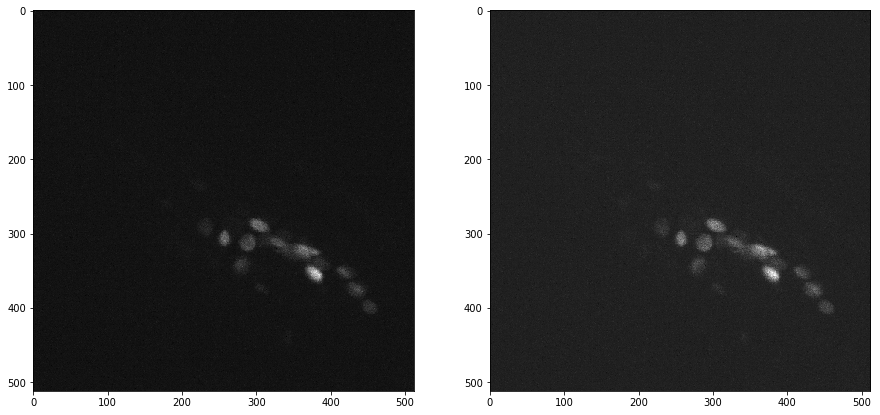

In [9]:
print('30ms sample')

level = 10

img_1 = volume_s1_c0_f1[level]
img_2 = volume_s1_c0_f3[level]

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_2, cmap="gray")
plt.show()

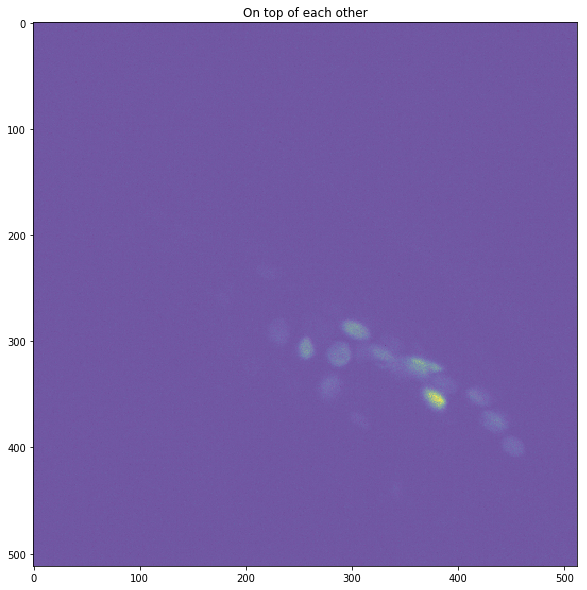

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1, cmap="plasma", alpha=0.5)
plt.imshow(img_2, cmap="viridis", alpha=0.5)
plt.title("On top of each other")
plt.show()

In this case, it seems there is no shift or if there is it is not significant.

In [11]:
def align_images(img_1, img_2):
    shift, error, diffphase = register_translation(img_1, img_2, 100)
        
    shift = -1 * shift
    img_1_shifted = fourier_shift(np.fft.fftn(img_1), shift)
    img_1_shifted = np.fft.ifftn(img_1_shifted).real
    
    return img_1_shifted, img_2

In [12]:
level = 10

img_1 = volume_s0_c0_f0[level]
img_2 = volume_s0_c0_f2[level]

img_1_shifted, img_2 = align_images(img_1,img_2)

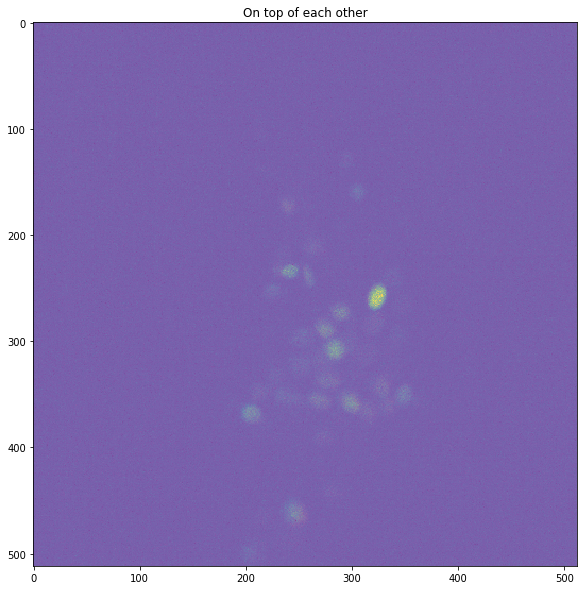

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1_shifted, cmap="plasma", alpha=0.5)
plt.imshow(img_2, cmap="viridis", alpha=0.5)
plt.title("On top of each other")
plt.show()

Good!

In [14]:
def align_volumes(volume_1, volume_2):
    volume_1_shifted = []
    for img_1, img_2 in zip(volume_1, volume_2):
        img_1_shifted, img_2 = align_images(img_1, img_2)
        volume_1_shifted.append(img_1_shifted)
    return volume_1_shifted, volume_2

In [15]:
img = volume_s0_c0_f0[level]

img_flipped_1 = np.fliplr(img)
img_flipped_2 = np.flipud(img)

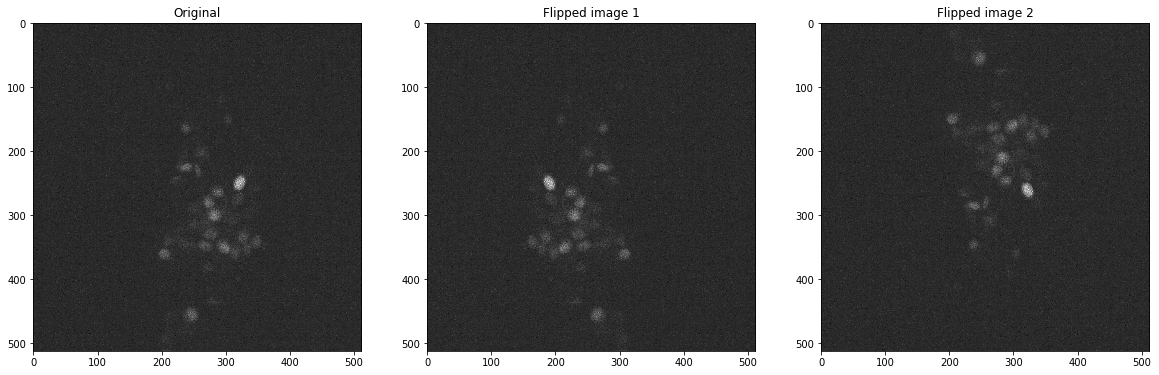

In [16]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Flipped image 1")
plt.imshow(img_flipped_1, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Flipped image 2")
plt.imshow(img_flipped_2, cmap="gray")

plt.show()

In [17]:
def augment_image(img):
    return [img, np.fliplr(img), np.flipud(img), np.fliplr(np.flipud(img))]

In [18]:
def augment_volumes(volume_1, volume_2):
    volume_1_augmented = []
    volume_2_augmented = []
    
    for img_1, img_2 in zip(volume_1, volume_2):
        volume_1_augmented.extend(augment_image(img_1))
        volume_2_augmented.extend(augment_image(img_2))
    return volume_1_augmented, volume_2_augmented

In [19]:
def is_overnoised(img,bright_pixel_percent=0.05):
    hist = exposure.histogram(img, nbins=2)[0]
    value = hist[1] # Number of bright points. (The less value, the less noise)
    n_pixels = img.shape[0] * img.shape[1]
    return value > n_pixels * bright_pixel_percent

In [20]:
def clean_volumes(volume_1, volume_2):
    volume_1_cleaned = []
    volume_2_cleaned = []
    
    for img_1, img_2 in zip(volume_1, volume_2):
        if is_overnoised(img_1) | is_overnoised(img_2):
            continue
        else:
            volume_1_cleaned.append(img_1)
            volume_2_cleaned.append(img_2)
    return volume_1_cleaned, volume_2_cleaned

In [21]:
# def equalize_adaphist_img(img):
#     image_rescaled = exposure.rescale_intensity(img, in_range=(0, 2**12 - 1))
#     rescaled_image_histeq = exposure.equalize_adapthist(image_rescaled)


# def equalize_adaphist_volumes():

In [22]:
def save_img_grayscale(img,sample_index,channel,z,frame,i,PATH):
    image_name = 'image_s'+str(sample_index)+'_c'+str(channel)+'_z'+str(z)+'_f'+str(frame)+'_'+str(i)+'.jpg'
    path = PATH + '/' + image_name
#     imageio.imwrite(path,np.array(img,dtype=np.uint8))
    plt.imsave(path,img,cmap='gray')

In [23]:
params = [{'clean':False, 'align':True, 'augment':False},
          {'clean':True, 'align':True, 'augment':False},
          {'clean':False, 'align':True, 'augment':True},
          {'clean':True, 'align':True, 'augment':True}]

In [24]:
def save_dataset(data_type,filenames, params, exp_name):
    DATA_PATH = exp_name + '_data_' + data_type
    
    SOURCE_PATH = '/source'
    TARGET_PATH = '/target'

    if not os.path.exists(DATA_PATH):
        os.mkdir(DATA_PATH)
        os.mkdir(DATA_PATH+SOURCE_PATH)
        os.mkdir(DATA_PATH+TARGET_PATH)
        os.mkdir(DATA_PATH+SOURCE_PATH+'/channel0')
        os.mkdir(DATA_PATH+SOURCE_PATH+'/channel1')
        os.mkdir(DATA_PATH+TARGET_PATH+'/channel0')
        os.mkdir(DATA_PATH+TARGET_PATH+'/channel1')

    file_indices = [i for i,elem in enumerate(filenames) if data_type in elem]
    
    for c in range(2):
        path1 = os.getcwd()+'/'+DATA_PATH+SOURCE_PATH+'/channel'+str(c)
        path2 = os.getcwd()+'/'+DATA_PATH+TARGET_PATH+'/channel'+str(c)
        
        volumes = []
        for file_index in file_indices:
            
            is_test = file_index==file_indices[0]
                            
            for i in range(4):
                volumes.append(get_volume(samples[file_index], channel=c, frame=i))
                     
            pairs = [(0,2),(1,3)]
            
            if is_test:
                TEST_SET_PATH = DATA_PATH+'/test_for_channel'+str(c)
                os.mkdir(TEST_SET_PATH)
                
                for ind,elem in enumerate(volumes[0]):
                    save_img_grayscale(elem,file_index,c,ind,0,'_',TEST_SET_PATH)
                    
                for ind,elem in enumerate(volumes[2]):
                    save_img_grayscale(elem,file_index,c,ind,2,'_',TEST_SET_PATH)
                    
                pairs = [(1,3)]
         
            if params['clean']:
                for p in pairs:
                    volumes[p[0]], volumes[p[1]] = clean_volumes(volumes[p[0]], volumes[p[1]])

            if params['align']:
                for p in pairs:
                    volumes[p[0]], volumes[p[1]] = align_volumes(volumes[p[0]], volumes[p[1]])

            if params['augment']: 
                for p in pairs:
                    volumes[p[0]], volumes[p[1]] = augment_volumes(volumes[p[0]], volumes[p[1]])

            for i,each in enumerate(volumes):
                if i==0 or i==1:
                    path = path1
                path = path2
                for ind,elem in enumerate(each):
                    save_img_grayscale(elem,file_index,c,ind//4+1,i,ind%4,path) 

In [ ]:
data_type = "5ms"
for exp_ind, param in enumerate(params):
    print("Saving the dataset for experiment " + str(exp_ind + 1))
    exp_name = "_".join([key for key, el in param.items() if el])
    save_dataset(data_type, filenames, param, exp_name)

In [ ]:
for g1,g2 in [(0,2)]:
    print(g1)
    print(g2)

In [ ]:
t = [(0,2),(1,3)]

In [ ]:
for p1 in t:
    print(p1)

In [ ]:
DATA_PATH = 'data_30ms'
SOURCE_PATH = '/source'
TARGET_PATH = '/target'

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
    os.mkdir(DATA_PATH+SOURCE_PATH)
    os.mkdir(DATA_PATH+TARGET_PATH)
    os.mkdir(DATA_PATH+SOURCE_PATH+'/channel0')
    os.mkdir(DATA_PATH+SOURCE_PATH+'/channel1')
    os.mkdir(DATA_PATH+TARGET_PATH+'/channel0')
    os.mkdir(DATA_PATH+TARGET_PATH+'/channel1')
    

for c in range(2):
    path1 = os.getcwd()+'/'+DATA_PATH+SOURCE_PATH+'/channel'+str(c)
    path2 = os.getcwd()+'/'+DATA_PATH+TARGET_PATH+'/channel'+str(c)
    for index in index_30ms:
        volume1 = get_volume(samples[index], channel=c, frame=0) 
        volume2 = get_volume(samples[index], channel=c, frame=1)
        volume3 = get_volume(samples[index], channel=c, frame=2)
        volume4 = get_volume(samples[index], channel=c, frame=3)
            
        # align volumes
        volume1, volume3 = align_volumes(volume1,volume3)
        volume2, volume4 = align_volumes(volume2,volume4)
        
        # augment volumes
        volume1, volume3 = augment_volumes(volume1,volume3)
        volume2, volume4 = augment_volumes(volume2,volume4)
        
        for ind,elem in enumerate(volume1):
            save_img_grayscale(elem,index,c,ind//4+1,0,ind%4,path1) 

        for ind,elem in enumerate(volume2):
            save_img_grayscale(elem,index,c,ind//4+1,1,ind%4,path1) 

        for ind,elem in enumerate(volume3):
            save_img_grayscale(elem,index,c,ind//4+1,2,ind%4,path2) 

        for ind,elem in enumerate(volume4):
            save_img_grayscale(elem,index,c,ind//4+1,3,ind%4,path2)  

In [ ]:
DATA_PATH = 'data_5ms'
SOURCE_PATH = '/source'
TARGET_PATH = '/target'

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
    os.mkdir(DATA_PATH+SOURCE_PATH)
    os.mkdir(DATA_PATH+TARGET_PATH)
    os.mkdir(DATA_PATH+SOURCE_PATH+'/channel0')
    os.mkdir(DATA_PATH+SOURCE_PATH+'/channel1')
    os.mkdir(DATA_PATH+TARGET_PATH+'/channel0')
    os.mkdir(DATA_PATH+TARGET_PATH+'/channel1')
    

for c in range(2):
    path1 = os.getcwd()+'/'+DATA_PATH+SOURCE_PATH+'/channel'+str(c)
    path2 = os.getcwd()+'/'+DATA_PATH+TARGET_PATH+'/channel'+str(c)
    for index in index_5ms:
        volume1 = get_volume(samples[index], channel=c, frame=0) 
        volume2 = get_volume(samples[index], channel=c, frame=1)
        volume3 = get_volume(samples[index], channel=c, frame=2)
        volume4 = get_volume(samples[index], channel=c, frame=3)
            
        # align volumes
        aligned_volume1, volume3 = align_volumes(volume1,volume3)
        aligned_volume2, volume4 = align_volumes(volume2,volume4)
        
        # augment volumes
        aug_volume1, aug_volume3 = augment_volumes(aligned_volume1,volume3)
        aug_volume2, aug_volume4 = augment_volumes(aligned_volume2,volume4)
        
        for ind,elem in enumerate(aug_volume1):
            save_img_grayscale(elem,index,c,ind//3+1,0,ind%3,path1) 

        for ind,elem in enumerate(aug_volume2):
            save_img_grayscale(elem,index,c,ind//3+1,1,ind%3,path1) 

        for ind,elem in enumerate(aug_volume3):
            save_img_grayscale(elem,index,c,ind//3+1,2,ind%3,path2) 

        for ind,elem in enumerate(aug_volume4):
            save_img_grayscale(elem,index,c,ind//3+1,3,ind%3,path2)  

In [ ]:
volume_s1_c1_f1 = get_volume(samples[1], channel=1, frame=1)

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(volume_s1_c1_f1[10], cmap="gray")
plt.show()

In [ ]:
volume_s1_c1_f1[10]

In [ ]:
volume_s1_c1_f1[10].min(),volume_s1_c1_f1[10].max()

In [ ]:
gray_img = cv2.imread(os.getcwd() + "/image2.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(gray_img,cmap='gray')
plt.show()

In [ ]:
gray_img

In [ ]:
def incr_small(pixel):
    if pixel < 100:
        return pixel +120
    elif pixel > 200:
        return pixel - 50
    else:
        return pixel 

plt.figure(figsize=(15,8))
plt.imshow(np.vectorize(incr_small)(gray_img),cmap='gray')
plt.show()

In [ ]:
plt.hist(volume_s1_c1_f1[10].flatten(),bins=256,range=[51,4095])
plt.show()

In [ ]:
a = np.clip(volume_s1_c1_f1[10],0,255)

In [ ]:
plt.hist(a.flatten(),bins=256,range=[51,4095])
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(a, cmap="gray")
plt.show()

In [ ]:
# imageio.imwrite(os.getcwd()+'/image.jpg',np.array(volume_s1_c1_f1[10],dtype=np.uint8))

In [ ]:
# plt.imsave(os.getcwd()+'/image2.jpg',np.array(volume_s1_c1_f1[10]),cmap='gray')

In [ ]:
# cv2.imread('data_5ms/source/channel0/image_s0_c0_z4_f0_0.jpg').shape

In [ ]:
# a = cv2.imread('data_5ms/source/channel0/image_s0_c0_z4_f0_0.jpg',cv2.IMREAD_GRAYSCALE).reshape(512,512,1)

In [ ]:
# np.expand_dims(a,0).shape